In [2]:
import datetime
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
import random
## Only when developing with VSCode in my repo 
# os.chdir('/home/nicolas/codeRepo/OceanPlatformControl') # here in Azure
# print(os.getcwd())
##
import pandas as pd
from ocean_navigation_simulator.problem_factories.Constructor import (
    Constructor,
)
from ocean_navigation_simulator.reinforcement_learning.missions.MissionGenerator import (
    MissionGenerator,
)
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner,
)
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.utils.misc import set_arena_loggers
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2
# Settings for where the problem csv is saved
my_path = os.getcwd()
results_folder = os.path.join(my_path, "tmp/missions/")
os.makedirs(results_folder, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Random Missions

In [3]:
# Settings for where the problem csv is saved
my_path = os.getcwd()
results_folder = os.path.join(my_path, "tmp/missions/")
os.makedirs(results_folder, exist_ok=True)
filename = 'problemsGOM_1.csv'

### 1. Arena Configuration and Mission configuration

In [4]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                #  "region": "Region 1"
            },
        },
        "forecast": None,#{
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         # "region": "Region 1",
        #     },
        #},
    },
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 1,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}

# change to this if basic setup works
set_arena_loggers(logging.DEBUG)
logging.getLogger("MissionGenerator").setLevel(logging.DEBUG)

config = {
    "scenario_config": arena_config,
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    "x_range": [-95.9, -78.52],
    "y_range": [20.22, 30],
    # "x_range": [-160, -105],
    # "y_range": [15, 40],
    "t_range": [  # ['2022-08-01T00:00:00+00:00', '2022-08-30T00:00:00+00:00'],
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=8, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=8, day=30, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": 24*6, #to be considered as feasible
    "target_distance_from_land": 0.5,
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.04,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * 24 * 7, #7 days here #
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 2,
    "random_missions_per_target": 8,
    "multi_agent": {
        "is_multi_agent": True,
        "nb_platforms": 4,
        "sampling_range_radius_km": 20,
        "sample_range_ttr_h": [70, 110], # this has to be a larger than the "feasible_mission_time_in_h"
        # as the multi-agent points are sampled from "feasible_mission_time_in_h" with added noise which might 
        # increase their ttr by quite a lot (so either this interval has to be increased or the other reduced)
    },
    "min_distance_from_hj_frame": 0.5,
    "min_distance_from_land": 0.5,
    "feasible_mission_time_in_h": [80, 90],
    "random_min_distance_from_target": 0.5,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
}

### 2. Run generation

In [6]:
nb_workers = 1 # nb_of different targets
all_problems = []
for worker in range(nb_workers):
    mission_generator = MissionGenerator(
        config=config
        | {
            "seed": 2022,#int(random.uniform(0, 1000000)),
            "cache_folder": results_folder + str(worker) + "_",
        },
    )
    problems, _, _ = mission_generator.cache_batch()
    all_problems.extend(problems)
df = pd.DataFrame([problem.to_dict() for problem in all_problems])
df.to_csv(results_folder + filename)

Starting to connect to c3


INFO:c3:Utils: Connect to c3 (25.50s)
INFO:arena.factory:Downloading 8 files to 'data/miss_gen_hindcast/'.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-15T00:00:00Z-2022-08-15T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-16T00:00:00Z-2022-08-16T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-17T00:00:00Z-2022-08-17T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-18T00:00:00Z-2022-08-18T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-19T00:00:00Z-2022-08-19T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-20T00:00:00Z-2022-08-20T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-21T00:00:00Z-2022-08-21T23:00:00Z.nc', 0.8MB.
INFO

feasible missions found


INFO:MissionGenerator:Generated Batch (167.11s)
INFO:MissionGenerator:Batch finished (167.11s)


### 3. Visualize generated Navigation Problems

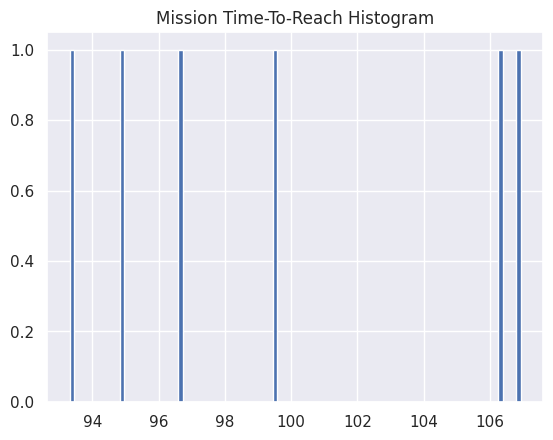

INFO:arena.factory:Downloading 6 files to 'data/miss_gen_hindcast/'.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-17T00:00:00Z-2022-08-17T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-18T00:00:00Z-2022-08-18T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-19T00:00:00Z-2022-08-19T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-20T00:00:00Z-2022-08-20T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-21T00:00:00Z-2022-08-21T23:00:00Z.nc', 0.8MB.
INFO:arena.factory:File already downloaded: 'GOMu0.04-expt_90.1m000-2022-2022-08-22T00:00:00Z-2022-08-22T23:00:00Z.nc', 0.8MB.
DEBUG:arena.factory:Hindcast Files: ['data/miss_gen_hindcast/GOMu0.04-expt_90.1m000-2022-2022-08-17T00:00:00Z-2022-08-17T23:00:00Z.nc', 'data/miss_gen_hindcast/GOMu0.04-

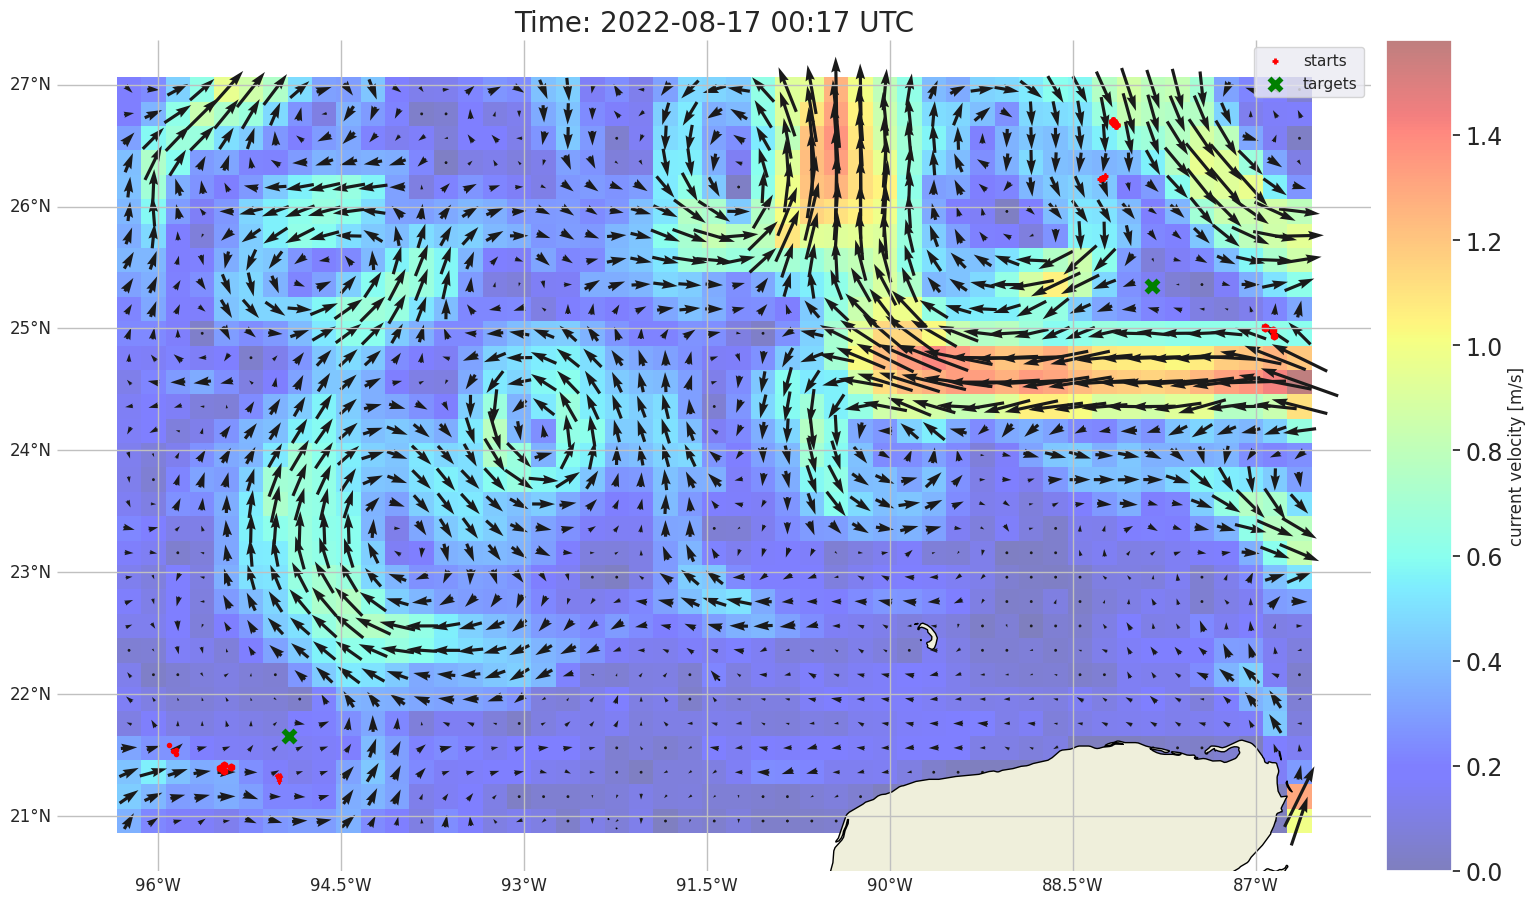

In [5]:
GenerationRunner.plot_ttr_histogram(results_folder, pb_filename=filename)
# visualize only first target and associated starts (which defines a c3 "mission") 
GenerationRunner.plot_starts_and_targets(
    results_folder=results_folder, pb_filename=filename, scenario_config=arena_config,
)